In [80]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')


In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')

In [4]:
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [5]:
meta_df = pd.read_excel('exp 6 transfer Apr2019.xlsx', sheet_name='sent for seq')
meta_df.rename(columns={'#': 'sample_number'}, inplace=True)
meta_df.sample_number = pd.to_numeric(meta_df.sample_number)

In [7]:
import json
with open(os.path.join('DNA','dnaseq', 'qualimap_multiqc_data','multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [8]:

qualimap_json.keys()

dict_keys(['report_data_sources', 'report_general_stats_data', 'report_general_stats_headers', 'report_multiqc_command', 'report_plot_data', 'report_saved_raw_data', 'config_analysis_dir_abs', 'config_analysis_dir', 'config_creation_date', 'config_git_hash', 'config_intro_text', 'config_report_comment', 'config_report_header_info', 'config_script_path', 'config_short_version', 'config_subtitle', 'config_title', 'config_version'])

In [9]:
qmap_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [10]:
len(qualimap_json['report_general_stats_data'])

1

In [11]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
bamqc_df = pd.DataFrame([_item_to_dict(k,v) for k,v in qualimap_json['report_general_stats_data'][0].items()])

In [12]:
bamqc_df.head()

,total_reads,mapped_reads,percentage_aligned,general_error_rate,mean_coverage,Key,median_coverage,median_insert_size,avg_gc,1_x_pc,5_x_pc,10_x_pc,30_x_pc,50_x_pc
0,550761.0,134228.0,24.371370,0.44,4.8599,12_1A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,79690.0,9854.0,12.365416,3.72,0.3646,21_DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,268388.0,54226.0,20.204331,0.18,4.9590,18_MIT0604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,221198.0,1103.0,0.498648,11.42,0.0442,17_Maricaulis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,261903.0,251977.0,96.210047,0.28,9.0282,06_1A3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
bamqc_df = bamqc_df.pivot_table(index='Key').reset_index()
bamqc_df = bamqc_df.loc[~bamqc_df.Key.isin(['08_1A3', '08_MIT9313'])]
bamqc_df[['sample_number', 'species']] = bamqc_df.Key.str.split('_', expand=True)
bamqc_df['sample_number'] = pd.to_numeric(bamqc_df['sample_number'])
bamqc_df = bamqc_df.loc[bamqc_df.sample_number != 8]

bamqc_df.head()


,Key,10_x_pc,1_x_pc,30_x_pc,50_x_pc,5_x_pc,avg_gc,general_error_rate,mapped_reads,mean_coverage,median_coverage,median_insert_size,percentage_aligned,total_reads,sample_number,species
0,01_1A3,99.665126,99.986713,44.556351,2.066889,99.956183,45.442369,0.30,818317.0,29.0857,28.0,153.0,99.578719,821779.0,1,1A3
1,02_DE,99.530857,99.948538,42.842870,1.027107,99.871411,45.545246,0.52,741707.0,28.4919,28.0,156.0,98.530492,752769.0,2,DE
2,03_MIT9313,99.511546,99.995106,49.137470,2.178381,99.926126,51.545547,0.21,544213.0,29.7018,29.0,114.0,98.872316,550420.0,3,MIT9313
3,04_MIT0604,99.686022,99.756750,73.074687,10.393352,99.751076,32.475995,0.19,366615.0,36.2127,36.0,160.0,68.248963,537173.0,4,MIT0604
4,04_Maricaulis,0.000000,0.853247,0.000000,0.000000,0.004720,60.340426,11.37,404.0,0.0180,0.0,148.0,0.246791,163701.0,4,Maricaulis


In [14]:
bamqc_df = pd.merge(bamqc_df, meta_df, on='sample_number', how='left')

In [15]:
bamqc_df.columns

Index(['Key', '10_x_pc', '1_x_pc', '30_x_pc', '50_x_pc', '5_x_pc', 'avg_gc',
       'general_error_rate', 'mapped_reads', 'mean_coverage',
       'median_coverage', 'median_insert_size', 'percentage_aligned',
       'total_reads', 'sample_number', 'species', 'sample', 'PRO', 'ALT',
       'exp', 'days', 'ng/ul', 'final volume'],
      dtype='object')

In [16]:
value_cols = ['sample', 'PRO', 'ALT',
       'exp', '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
       
         'percentage_aligned','median_coverage','mean_coverage','median_insert_size',
        'general_error_rate', 'mapped_reads', 'total_reads'
             ]
        
pct_cols = [ '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
         'percentage_aligned']
with pd.ExcelWriter('bamqc_stats.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for i in bamqc_df.species.unique():
        bamqc_pdf = bamqc_df.loc[bamqc_df.species.isin([i])].pivot(index='sample_number', columns='species', 
                               values=value_cols)
        bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
        bamqc_pdf.rename(columns=qmap_titles, inplace=True)
        sheetname = f'{i} bamqc'
        bamqc_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column('F:J', None, format2)
        worksheet.set_column('L:L', None, format1)
        
        
        worksheet.conditional_format(f'F1:H{bamqc_df.shape[0]+2}', {'type': 'data_bar'})
        worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})
    



In [17]:
import json
with open(os.path.join('DNA','dnaseq_trimmed', 'multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [18]:
trimmed_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [19]:
len(qualimap_json['report_general_stats_data'])

4

In [21]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
trimmed_df = pd.DataFrame([
    _item_to_dict(k,v) 
    for d in qualimap_json['report_general_stats_data']
    for k,v in d.items()
])

In [22]:
trimmed_df.head()

,total_reads,mapped_reads,percentage_aligned,general_error_rate,mean_coverage,median_coverage,median_insert_size,avg_gc,1_x_pc,5_x_pc,...,forward_only_surviving_pct,reverse_only_surviving,reverse_only_surviving_pct,dropped,dropped_pct,percent_gc,avg_sequence_length,total_sequences,percent_duplicates,percent_fails
0,488749.0,8101.0,1.657497,2.13,0.2863,0.0,154.0,45.754564,14.741716,0.159721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65170.0,7893.0,12.111401,2.10,0.2794,0.0,154.0,45.670117,14.524395,0.117342,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,489657.0,15149.0,3.093798,2.02,0.5048,0.0,155.0,45.738068,24.717820,0.413449,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,489977.0,1455.0,0.296953,3.89,0.0886,0.0,128.0,53.353191,0.461617,0.375300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,491414.0,420148.0,85.497768,0.09,38.4190,38.0,153.0,32.643963,99.754840,99.705684,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
trimmed_df['Key'].unique()



array(['snippy_19_DE_all', 'snippy_19_DE_filtered', 'snippy_19_1A3_all',
       'snippy_19_MIT9313_all', 'snippy_19_MIT0604_all',
       'snippy_19_MIT0604_filtered', 'snippy_10_MIT9313_all',
       'snippy_10_MIT0604_filtered', 'snippy_10_MIT0604_all',
       'snippy_10_1A3_all', 'snippy_10_DE_all', 'snippy_10_1A3_filtered',
       'snippy_17_DE_filtered', 'snippy_17_DE_all',
       'snippy_17_MIT9313_all', 'snippy_17_MIT0604_filtered',
       'snippy_17_MIT0604_all', 'snippy_17_1A3_all',
       'snippy_13_MIT0604_all', 'snippy_13_MIT9313_all',
       'snippy_13_1A3_filtered', 'snippy_13_DE_all', 'snippy_13_1A3_all',
       'snippy_13_MIT0604_filtered', 'snippy_11_MIT0604_all',
       'snippy_11_1A3_all', 'snippy_11_MIT0604_filtered',
       'snippy_11_1A3_filtered', 'snippy_11_DE_all',
       'snippy_11_MIT9313_all', 'snippy_20_DE_filtered',
       'snippy_20_MIT0604_all', 'snippy_20_1A3_all',
       'snippy_20_MIT0604_filtered', 'snippy_20_DE_all',
       'snippy_20_MIT9313_all', 's

In [31]:
def _key_to_sample_species(x):
    mode = None
    if x.startswith('200219Seg_D20-16'):
        idx = x.replace('200219Seg_D20-', '').replace('_1_sequence','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'fastqc'
        species = None
    elif x.startswith('trim_200219Seg_D20'):
        idx = x.replace('trim_200219Seg_D20-', '').replace('_1_sequence_P','').replace('_2_sequence_P','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'trimmomatic'
        species = None
    elif x.startswith('freebayes_'):
        sample_number = None
        command = 'freebayes'
        species = x.replace('freebayes_', '')
    elif x.startswith('snippy_'):
        _, idx, species, mode = x.split('_')
        sample_number = pd.to_numeric(idx) 
        command = 'bamqc'
    return pd.Series({
        'species' : species,
         'mode' :mode,
        'sample_number' :sample_number,
        'command' : command,
    })

trimmed_df = pd.concat([trimmed_df, trimmed_df['Key'].apply(_key_to_sample_species)], axis=1)


In [55]:
trimmed_df = trimmed_df.loc[trimmed_df['sample_number'] != 8]

In [32]:
trimmed_df = pd.merge(trimmed_df, meta_df, on='sample_number', how='left')

In [ ]:
trimmed_df['pair'] = trimmed_df['PRO'] + ',' + trimmed_df['ALT']

In [34]:
trimmed_df.columns

Index(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc',
       ...
       'mode', 'sample_number', 'command', 'sample', 'PRO', 'ALT', 'exp',
       'days', 'ng/ul', 'final volume'],
      dtype='object', length=119)

In [35]:
trimmed_df.head()

,total_reads,mapped_reads,percentage_aligned,general_error_rate,mean_coverage,median_coverage,median_insert_size,avg_gc,1_x_pc,5_x_pc,...,mode,sample_number,command,sample,PRO,ALT,exp,days,ng/ul,final volume
0,488749.0,8101.0,1.657497,2.13,0.2863,0.0,154.0,45.754564,14.741716,0.159721,...,all,19.0,bamqc,10B,MIT0604,DE,6,440,6.25,100
1,65170.0,7893.0,12.111401,2.10,0.2794,0.0,154.0,45.670117,14.524395,0.117342,...,filtered,19.0,bamqc,10B,MIT0604,DE,6,440,6.25,100
2,489657.0,15149.0,3.093798,2.02,0.5048,0.0,155.0,45.738068,24.717820,0.413449,...,all,19.0,bamqc,10B,MIT0604,DE,6,440,6.25,100
3,489977.0,1455.0,0.296953,3.89,0.0886,0.0,128.0,53.353191,0.461617,0.375300,...,all,19.0,bamqc,10B,MIT0604,DE,6,440,6.25,100
4,491414.0,420148.0,85.497768,0.09,38.4190,38.0,153.0,32.643963,99.754840,99.705684,...,all,19.0,bamqc,10B,MIT0604,DE,6,440,6.25,100


In [54]:
bamqc_df.head()

,Key,10_x_pc,1_x_pc,30_x_pc,50_x_pc,5_x_pc,avg_gc,general_error_rate,mapped_reads,mean_coverage,...,total_reads,sample_number,species,sample,PRO,ALT,exp,days,ng/ul,final volume
0,01_1A3,99.665126,99.986713,44.556351,2.066889,99.956183,45.442369,0.30,818317.0,29.0857,...,821779.0,1,1A3,Axenic,Axenic,1A3,0,0,30,100
1,02_DE,99.530857,99.948538,42.842870,1.027107,99.871411,45.545246,0.52,741707.0,28.4919,...,752769.0,2,DE,Axenic,Axenic,DE,0,0,10,100
2,03_MIT9313,99.511546,99.995106,49.137470,2.178381,99.926126,51.545547,0.21,544213.0,29.7018,...,550420.0,3,MIT9313,Axenic,MIT9313,Axenic,0,0,0.6,100
3,04_MIT0604,99.686022,99.756750,73.074687,10.393352,99.751076,32.475995,0.19,366615.0,36.2127,...,537173.0,4,MIT0604,Axenic,MIT0604,Axenic,0,0,6,100
4,04_Maricaulis,0.000000,0.853247,0.000000,0.000000,0.004720,60.340426,11.37,404.0,0.0180,...,163701.0,4,Maricaulis,Axenic,MIT0604,Axenic,0,0,6,100


In [37]:
trimmed_df.columns

Index(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc',
       ...
       'mode', 'sample_number', 'command', 'sample', 'PRO', 'ALT', 'exp',
       'days', 'ng/ul', 'final volume'],
      dtype='object', length=119)

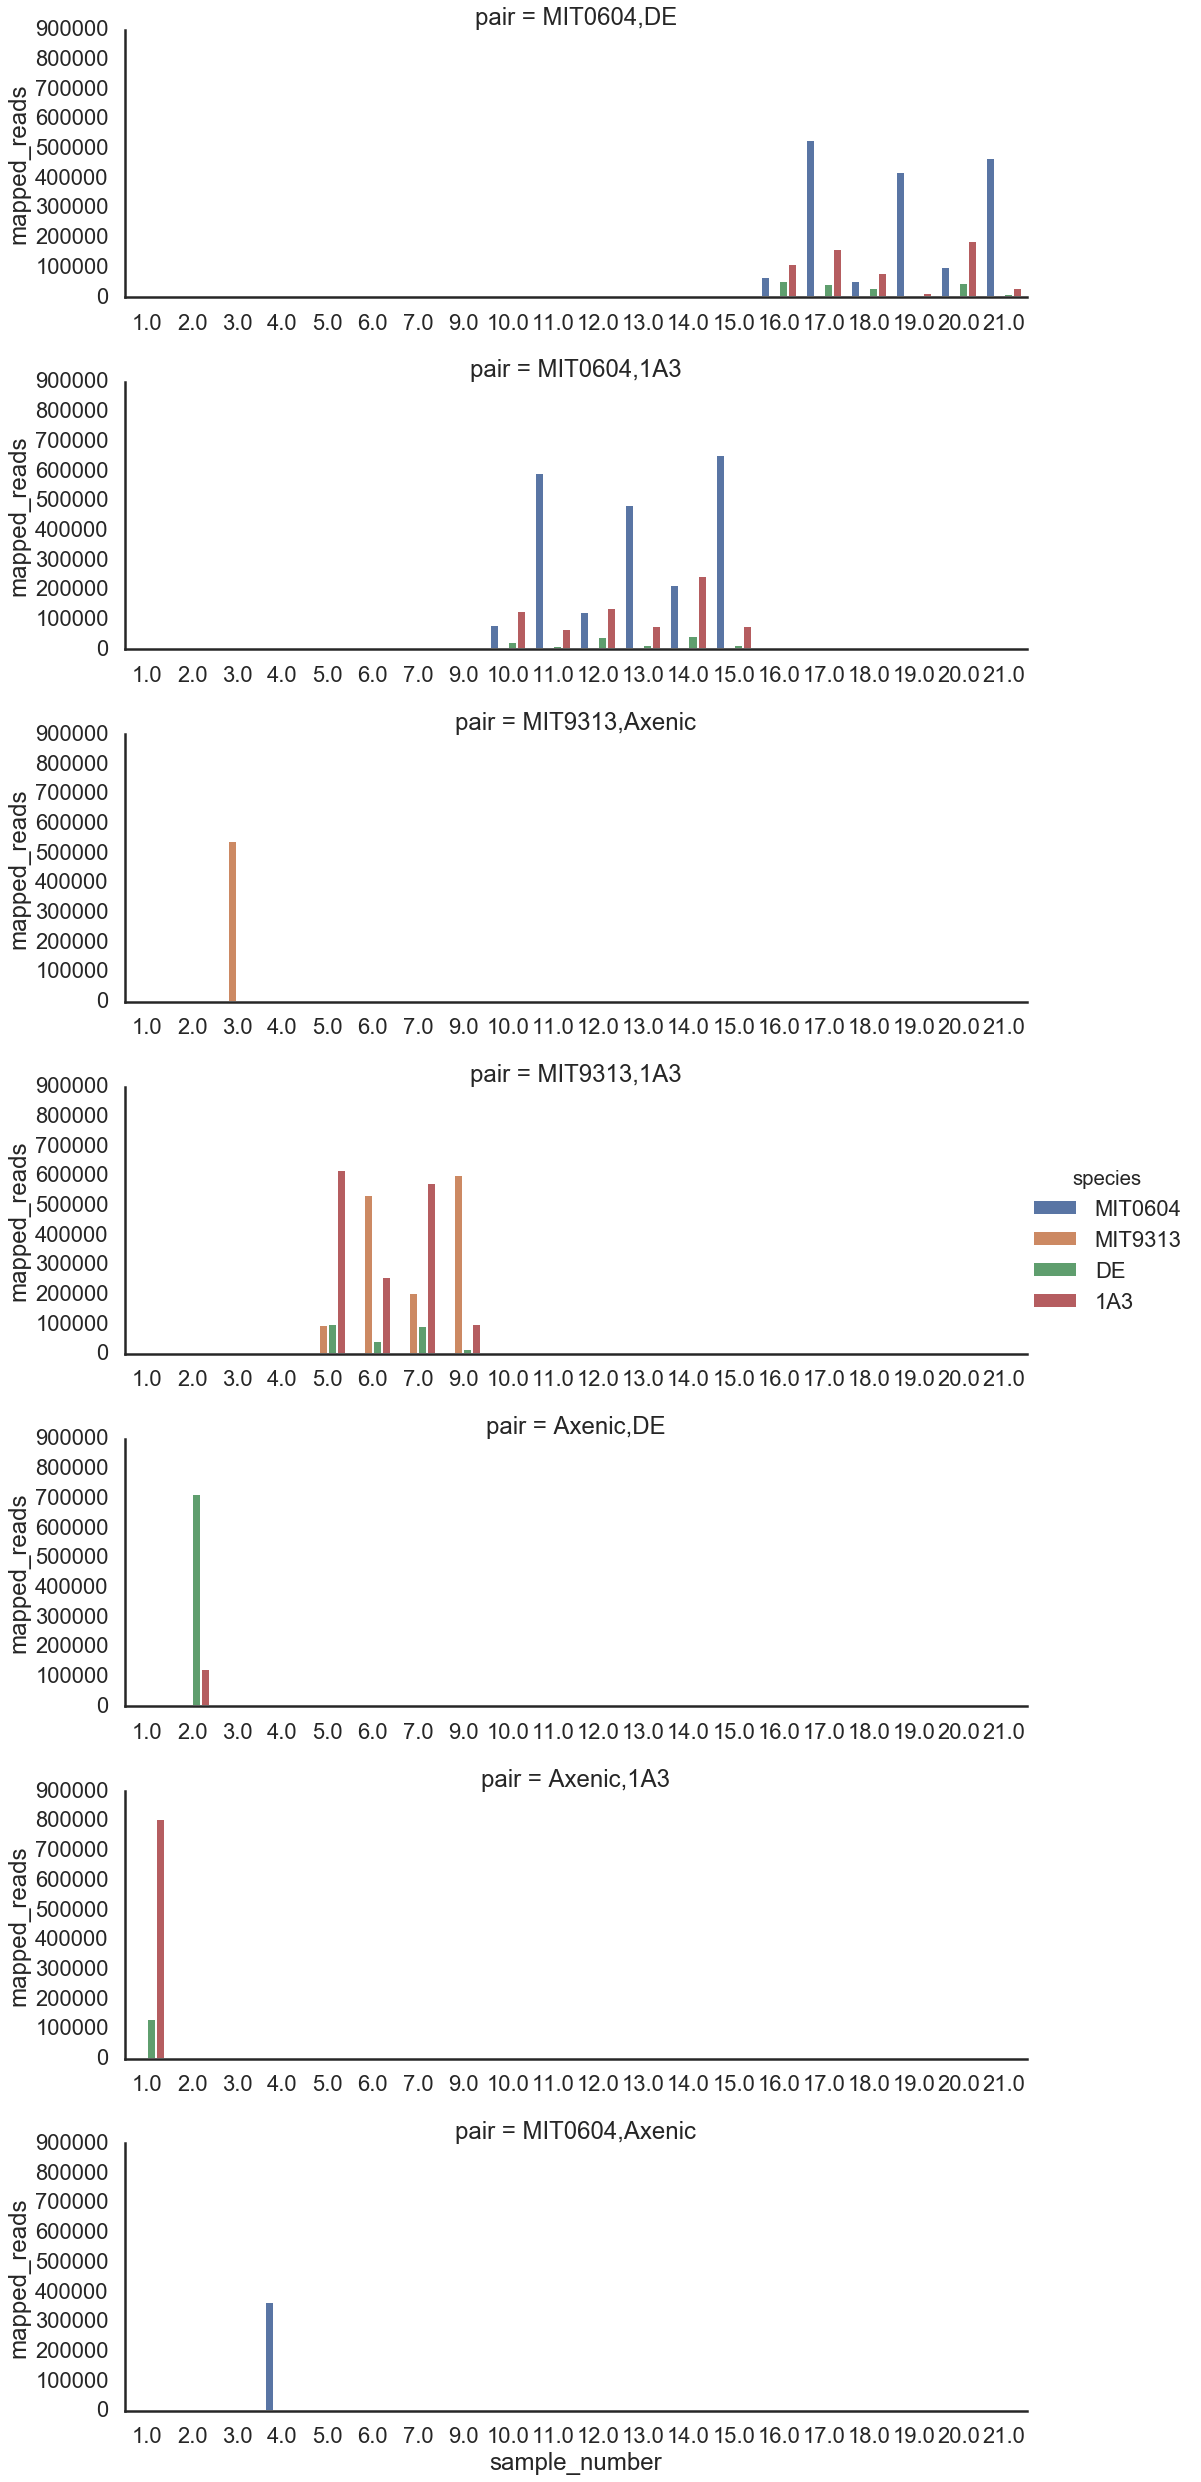

In [81]:
#for i in trimmed_df['pair'].dropna().unique():
sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'all')
 #                                   & (trimmed_df['pair'] == i)
                                   ],
                x='sample_number', y='mapped_reads', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
#plt.title(i)

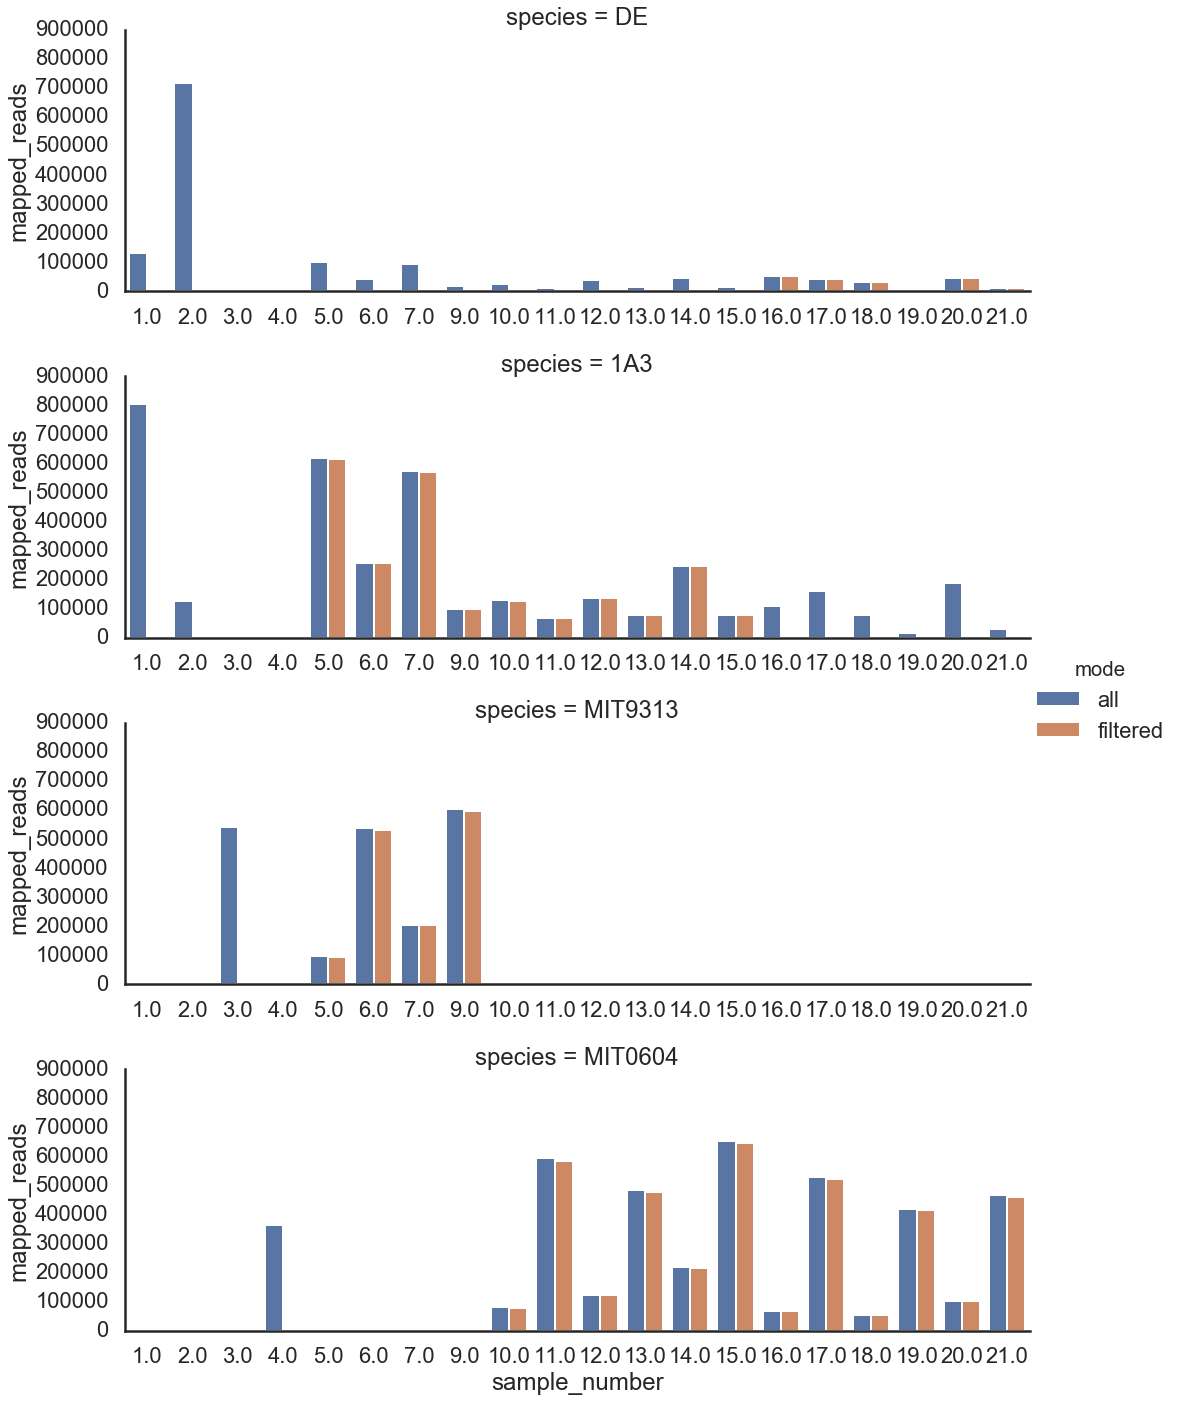

In [82]:
# pd.options.display.float_format = '{:d}'.format
sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc')],
            x='sample_number', y='mapped_reads', 
           row='species', hue='mode', sharex=False,
           aspect=3, kind='bar')

In [83]:
 trimmed_df.sample_number.dtypes

dtype('float64')

In [100]:
bamqc_df['trim'] = 'adapter'
trimmed_df['trim'] = 'Q>20'
pd.options.display.float_format = '{:.0f}'.format

merged_stat_df = pd.concat([
    bamqc_df.loc[~bamqc_df.species.isin(['Maricaulis '])], 
    trimmed_df.loc[
        (trimmed_df['command'] == 'bamqc') & 
        ((trimmed_df['mode'] == 'filtered') |
         ((trimmed_df['sample_number'] < 5)  & 
          (trimmed_df.PRO == trimmed_df.species) | (trimmed_df.ALT == trimmed_df.species)))
                                            ] 
                                            ],
        )

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [101]:
merged_stat_df.species = merged_stat_df.species.str.strip()

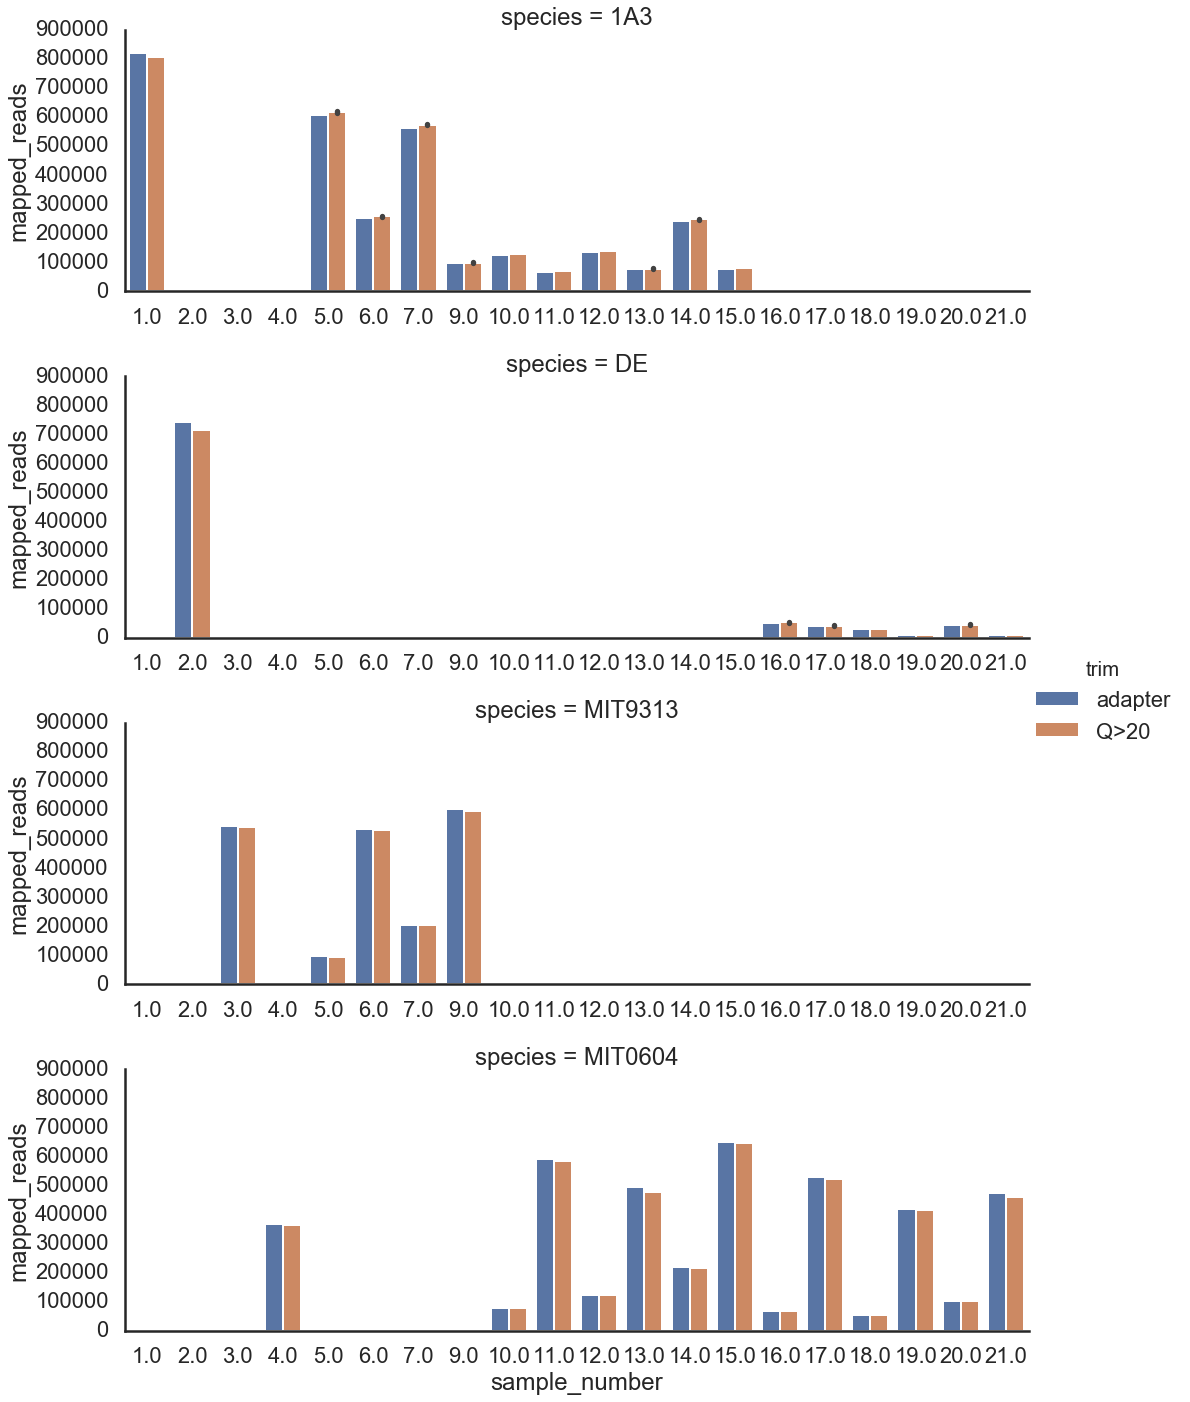

In [102]:
sns.catplot(data=merged_stat_df,
            x='sample_number', y='mapped_reads', 
           row='species', hue='trim', sharex=False,
           aspect=3, kind='bar')

Text(0.5, 1, 'mapped reads')

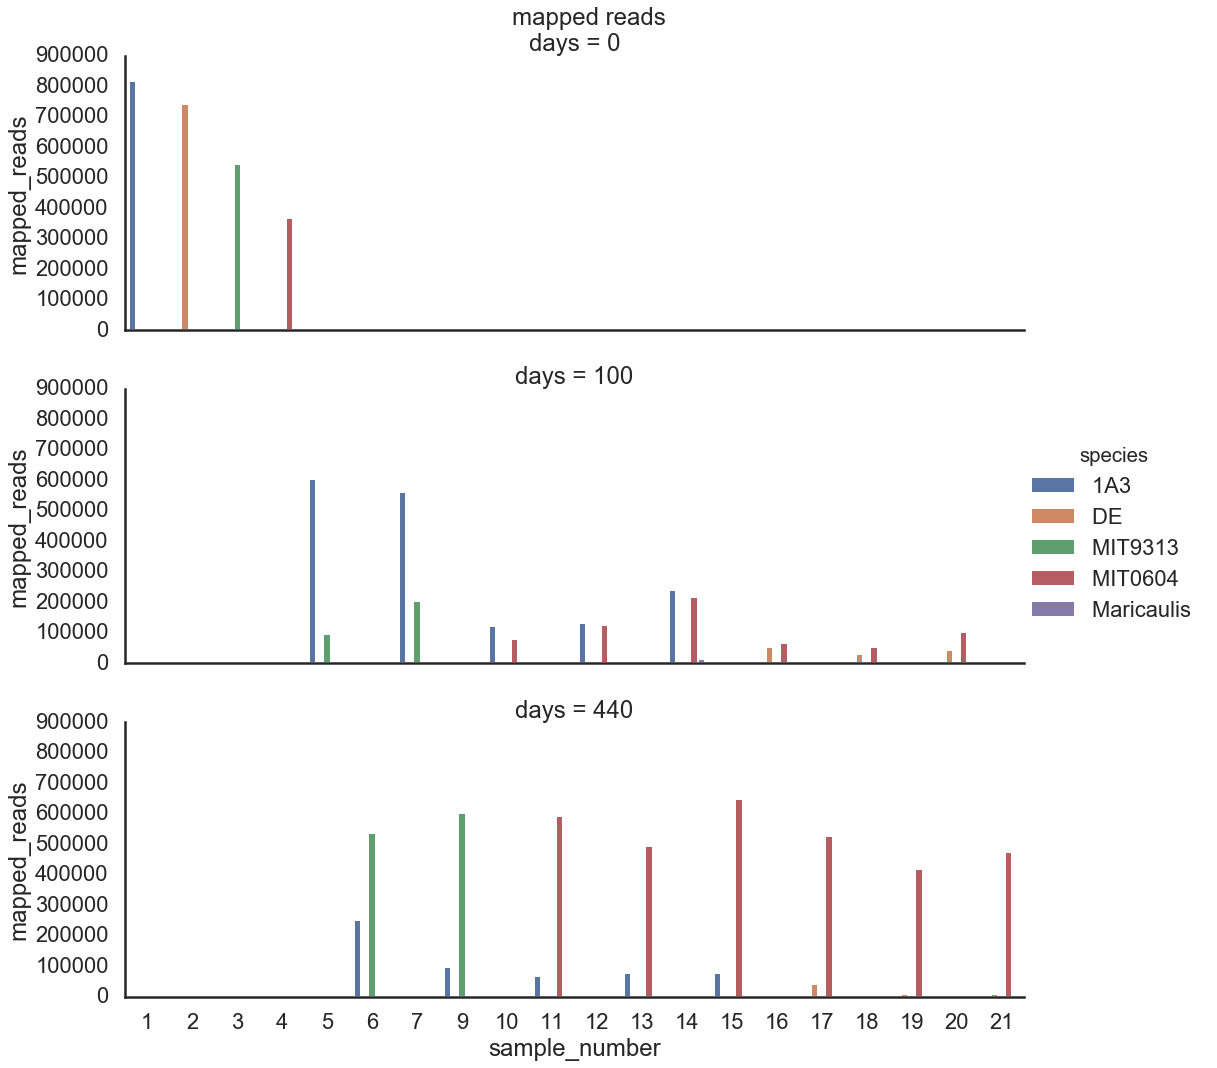

In [94]:
sns.set_style('white')
sns.set_context('poster')
sns.catplot(data=bamqc_df, x='sample_number', y='mapped_reads',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('mapped reads', y=1)

Text(0.5, 1, '% cov > 10x')

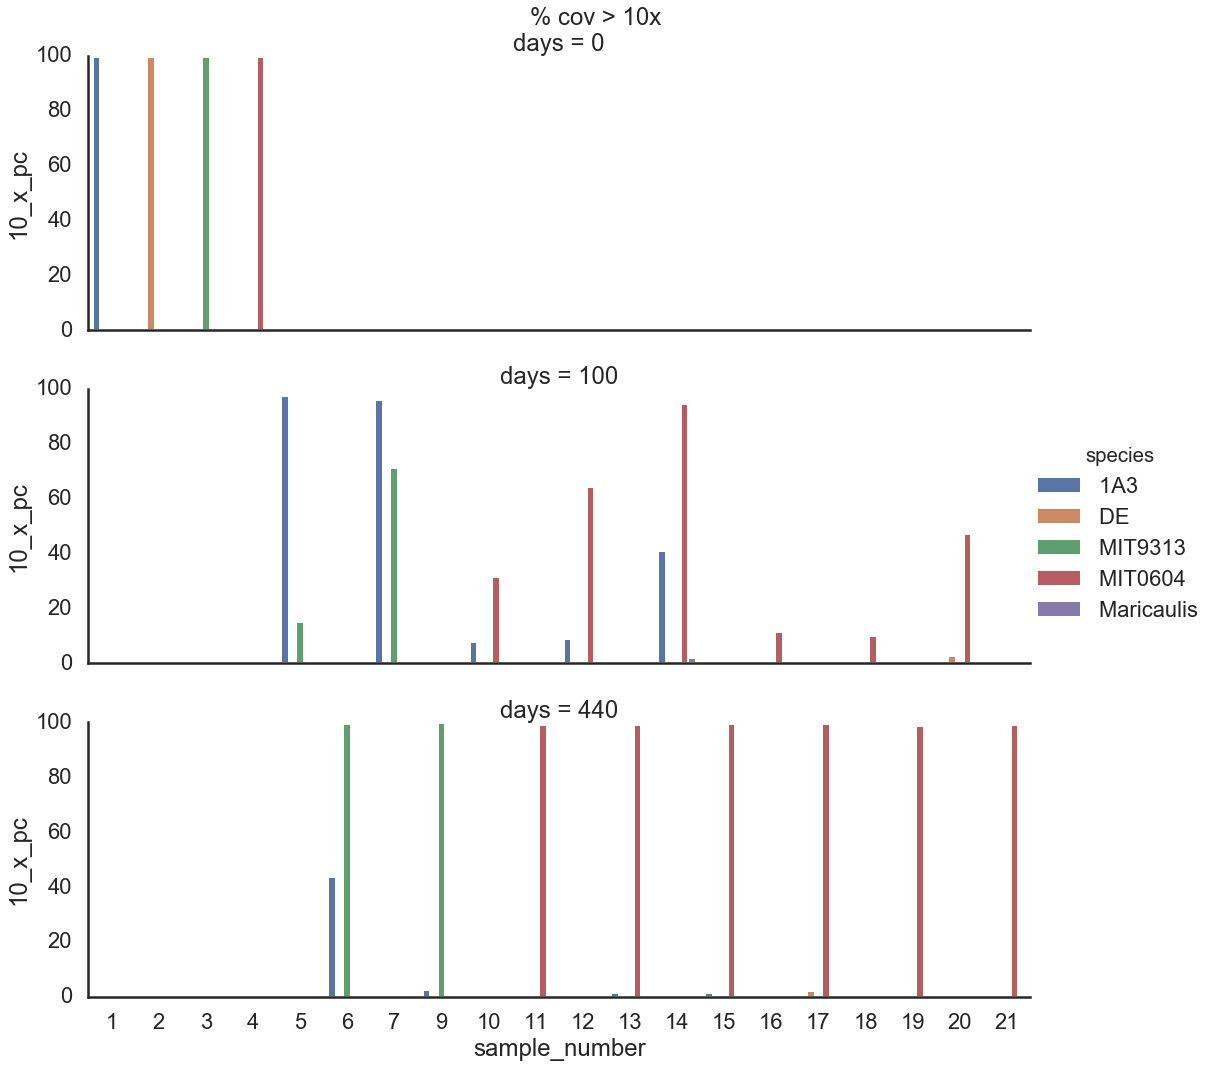

In [95]:
sns.set_style('white')
#sns.set_context('paper')
sns.catplot(data=bamqc_df, x='sample_number', y='10_x_pc',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('% cov > 10x', y=1)

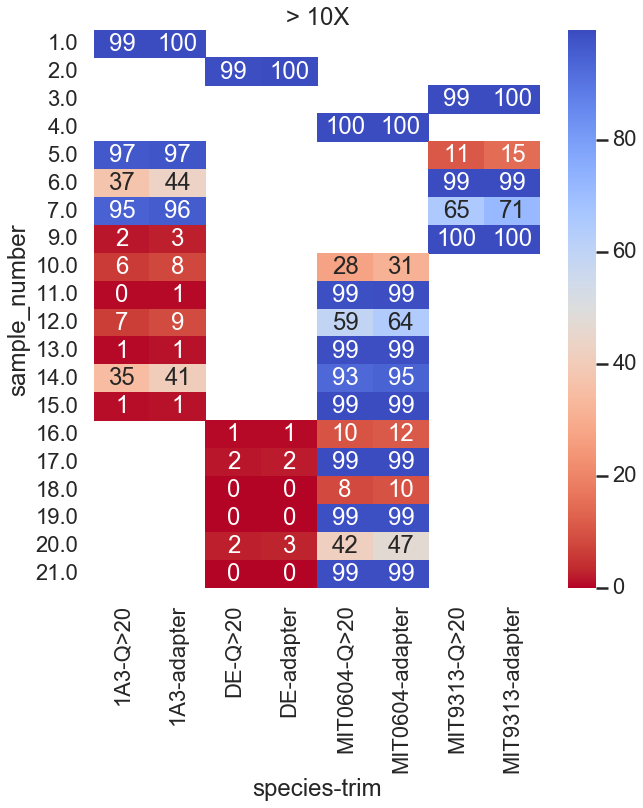

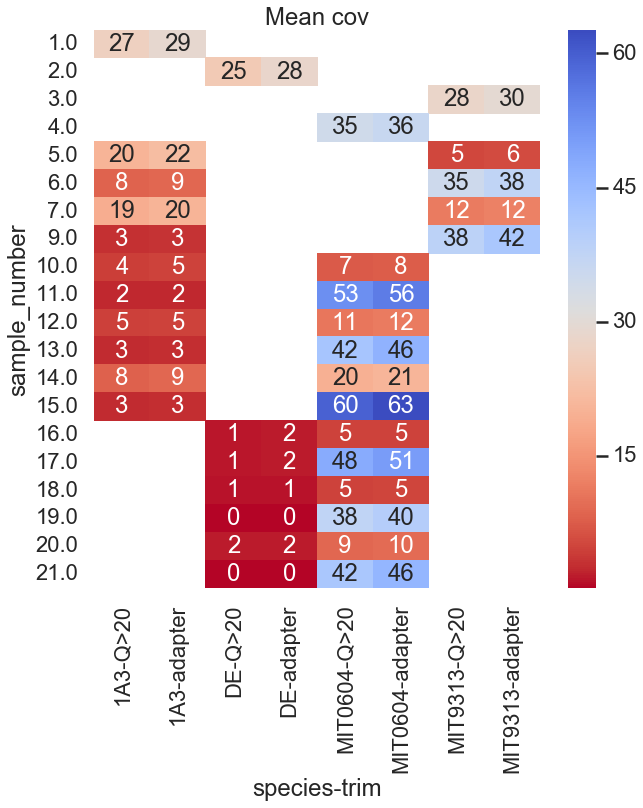

In [151]:
sns.set_context('poster')
value_cols = [  '10_x_pc',
         'mean_coverage',
              #'mapped_reads'
             ]

for v in value_cols:
    # 'sample', 'PRO', 'ALT', 'exp',
    plt.figure(figsize=(10,10))
    
    bamqc_pdf = merged_stat_df.pivot_table(index='sample_number', columns=['species', 'trim'], 
                           values=[v]).droplevel(level=0, axis='columns')
    #bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
    #bamqc_pdf.rename(columns=qmap_titles, inplace=True)
    sns.heatmap(bamqc_pdf, cmap='coolwarm_r',
                  annot=True, fmt='.0f')
    plt.title(qmap_titles[v])
    plt.show()

In [106]:
#from glob import glob
#data_dpath = os.path.join('DNA','freebayes')
data_dpath = os.path.join('DNA','dnaseq_trimmed')
# ##INFO=<ID=ANN,Number=.,Type=String,
#Description="Functional annotations: 'Allele | Annotation | Annotation_Impact | 
#            Gene_Name | Gene_ID | Feature_Type | Feature_ID | Transcript_BioType | 
#              Rank | HGVS.c | HGVS.p | 
# cDNA.pos / cDNA.length | CDS.pos / CDS.length | AA.pos / AA.length | Distance | ERRORS / WARNINGS / INFO' ">
def _parse_csv(t):
    ANN_columns = [
        'Allele', 'Annotation',  'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
        'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p', 'cDNA.pos',  'CDS.pos', 
        'AA.pos', 'Distance', 'ERRORS'
    ]
    #idx = 160000+i
    #dname = f'D20-{idx}-4500T'
    #glob(os.path.join(data_dpath, dname,'**', '*.csv'), recursive=True)
    fpath = os.path.join(data_dpath, #f'freebayes_{t}',
                         f'freebayes_{t}.tab')
    df =  pd.read_csv(fpath, sep='\t') 
    df['species'] = t
    df.ANN = df.ANN.str.split(',')
    df = df.apply( pd.Series.explode )


    df[ANN_columns] = df['ANN'].str.split('|', expand=True)
    df = df.drop('ANN', axis=1)
    return df

df_MIT9313 = _parse_csv('MIT9313') 
df_MIT0604 = _parse_csv('MIT0604') 
df_DE = _parse_csv('DE') 
df_1A3 = _parse_csv('1A3') 


In [265]:
def parse_freebayes(genome):
    df_s =  _parse_csv(genome) 
    id_vars=['CHROM', 'POS', 'TYPE', 'REF', 'ALT', 
       'species', 'Allele', 'Annotation', 'Impact', 'Gene_Name', 'Gene_ID',
       'Feature_Type', 'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c',
       'HGVS.p', 'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS']


    d = df_s.melt(id_vars=id_vars)
    d['variable'] = d['variable'].str.replace('D20-1600', '')
    d[['sample_number', 'variable']] = d['variable'].str.split('.',expand=True)
    d['sample_number'] = pd.to_numeric(d['sample_number'])

    pdf = d.pivot_table(index=(id_vars+['sample_number']), columns=['variable'], aggfunc='first', #values='value',
                   ).droplevel(level=0, axis='columns').reset_index() 
    
    pdf['good_call'] = (pdf.DP > 10) & (pdf.GQ > 20)
    mask = (~pdf.AO.astype(str).str.contains(',', na=False, regex=False) & 
            ~pdf.DP.astype(str).str.contains(',', na=False, regex=False) &
            (pdf['DP'] != 0) & pdf['good_call'])
    try: 
        pdf.loc[mask, 'fraction_Alt'] = pdf.loc[mask, 'AO'] / pdf.loc[mask, 'DP']
    except Exception:
        pdf['fraction_Alt'] = ''

    
    pdf['culture'] = 'Co_Culture'
    pdf.loc[pdf['sample_number']<=4, 'culture'] = 'Axenic'
    
    df_genome = pd.read_feather(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.feather.gz'))
    #df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
    #                          sheet_name='9313+1A3')
    genome_cols = ['gene_id', 'pmt_id', 'type',  'strand', 
       'product']
    mpdf = pd.merge(pdf, 
                    df_genome[genome_cols], left_on='Gene_Name', right_on='gene_id', 
                    how='left'
                   )
    #mpdf[['PMTID1', 'PMTID2']] = mpdf.pmt_id.str.split(',', expand=True)
    mpdf = pd.merge(mpdf, meta_df, on='sample_number', how='left')
    mpdf['good_call'] = (mpdf.DP > 10) & (mpdf.GQ > 20)
    mpdf.loc[mpdf.good_call & (mpdf.ALT_x == mpdf.GT), 'call'] = 1
    mpdf.loc[mpdf.good_call & (mpdf.REF == mpdf.GT), 'call'] = 0
    mpdf.loc[mpdf.good_call & (mpdf.REF != mpdf.GT) & (mpdf.ALT_x != mpdf.GT), 'call'] = -1
    return mpdf

In [266]:
dfs = dict()
for s in ['MIT0604', 'MIT9313', 'DE', '1A3']:
    dfs[s] = parse_freebayes(s)


C:\Users\wosnat\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [267]:
df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
                              sheet_name='9313+1A3')
df_DE_MIT9313.rename(columns={'log 2 fold change coculture/axenic' : 'log Fold Change'}, inplace=True)
de_cols = ['Synonym', 'q Value ', 'log Fold Change']
dfs['MIT9313'][['PMTID1', 'PMTID2']] = dfs['MIT9313'].pmt_id.str.split(',', expand=True)

dfs['MIT9313'] = pd.merge(dfs['MIT9313'], 
                df_DE_MIT9313[de_cols], left_on='PMTID1', right_on='Synonym', 
                how='left'
               )


In [269]:
all_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'RO', 'fraction_Alt', 'culture', 'gene_id', 'pmt_id',
       'type', 'strand', 'product', 'pmt_id', 'PMTID2', 'Synonym', 'q Value ',
       'log Fold Change', 'sample', 'PRO', 'ALT_y', 'exp',
       'days', 'ng/ul', 'final volume']
 

index_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'Annotation', 'Impact',
              'HGVS.p', 'HGVS.c', 'CDS.pos', 'AA.pos',
              'gene_id', 'pmt_id', 'type', 'strand', 'product']
additional_index_cols = ['q Value ', 'log Fold Change',]

column_cols = ['PRO', 'ALT_y', 'days','sample', ]
value_cols = ['call', 'fraction_Alt', 'DP', 'AO', 'RO','GQ','GT',  ]
species= 'MIT9313'


condition_format_cols = {
    'MIT9313' : ['T7:X10000', 'Y7:AC10000' ],
    'MIT0604' : ['R7:AD10000', 'AE7:AQ10000' ],
    '1A3' : ['R7:AB10000', 'AC7:AM10000' ],
    'DE' : ['R7:X20000', 'Y7:AE10000' ],
    
}  
fraction_cols = {
    'MIT9313' :  'Y:AC',
    'MIT0604' :  'AE:AQ',
    '1A3' : 'AC:AM' ,
    'DE' :  'Y:AE' ,
    
}  


#agg_f = lambda x : ' | '.join(x.unique())
with pd.ExcelWriter('var_calls_5x5_MIT9313.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for species, col in zip(['MIT9313', 'MIT0604', '1A3', 'DE'], ['PRO', 'PRO', 'ALT_y', 'ALT_y']):
        actual_index_cols = index_cols
        if species == 'MIT9313':
            actual_index_cols = index_cols + additional_index_cols
        excel_pdf = dfs[species].loc[dfs[species]['type'].isin(['CDS'])].fillna('').pivot_table(
            index=actual_index_cols, columns=column_cols,
            aggfunc='first', margins=False, values=value_cols,
            fill_value='',
        ).reindex(columns=value_cols, level=0,
        ).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',
        ).reindex(columns=['Axenic', 'MIT9313', 'MIT0604'], level='PRO',).reset_index()
        excel_pdf = excel_pdf.loc[excel_pdf['call'].replace('',np.NaN).std(axis=1) != 0]
        sheetname = f'{species} calls'
        excel_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column(fraction_cols[species], None, format1)
        if species == 'MIT9313':
            worksheet.set_column('R:S', None, format1)
        worksheet.set_column('Q:Q', 30)  # Col 1 has format1.
        worksheet.set_column('G:G', 12)  # Col 1 has format1.
                
        worksheet.conditional_format(condition_format_cols[species][0], 
                                     {'type': '2_color_scale',                               
                                      'min_color': '#b7efcd', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#ffbcbc'
                                     })
        worksheet.conditional_format(condition_format_cols[species][1],  
                                     {'type': '2_color_scale',                               
                                      'min_color': 'white', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#f69e7b'
                                     })
        #worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})


Text(0.5, 1, 'MIT9313 calls')

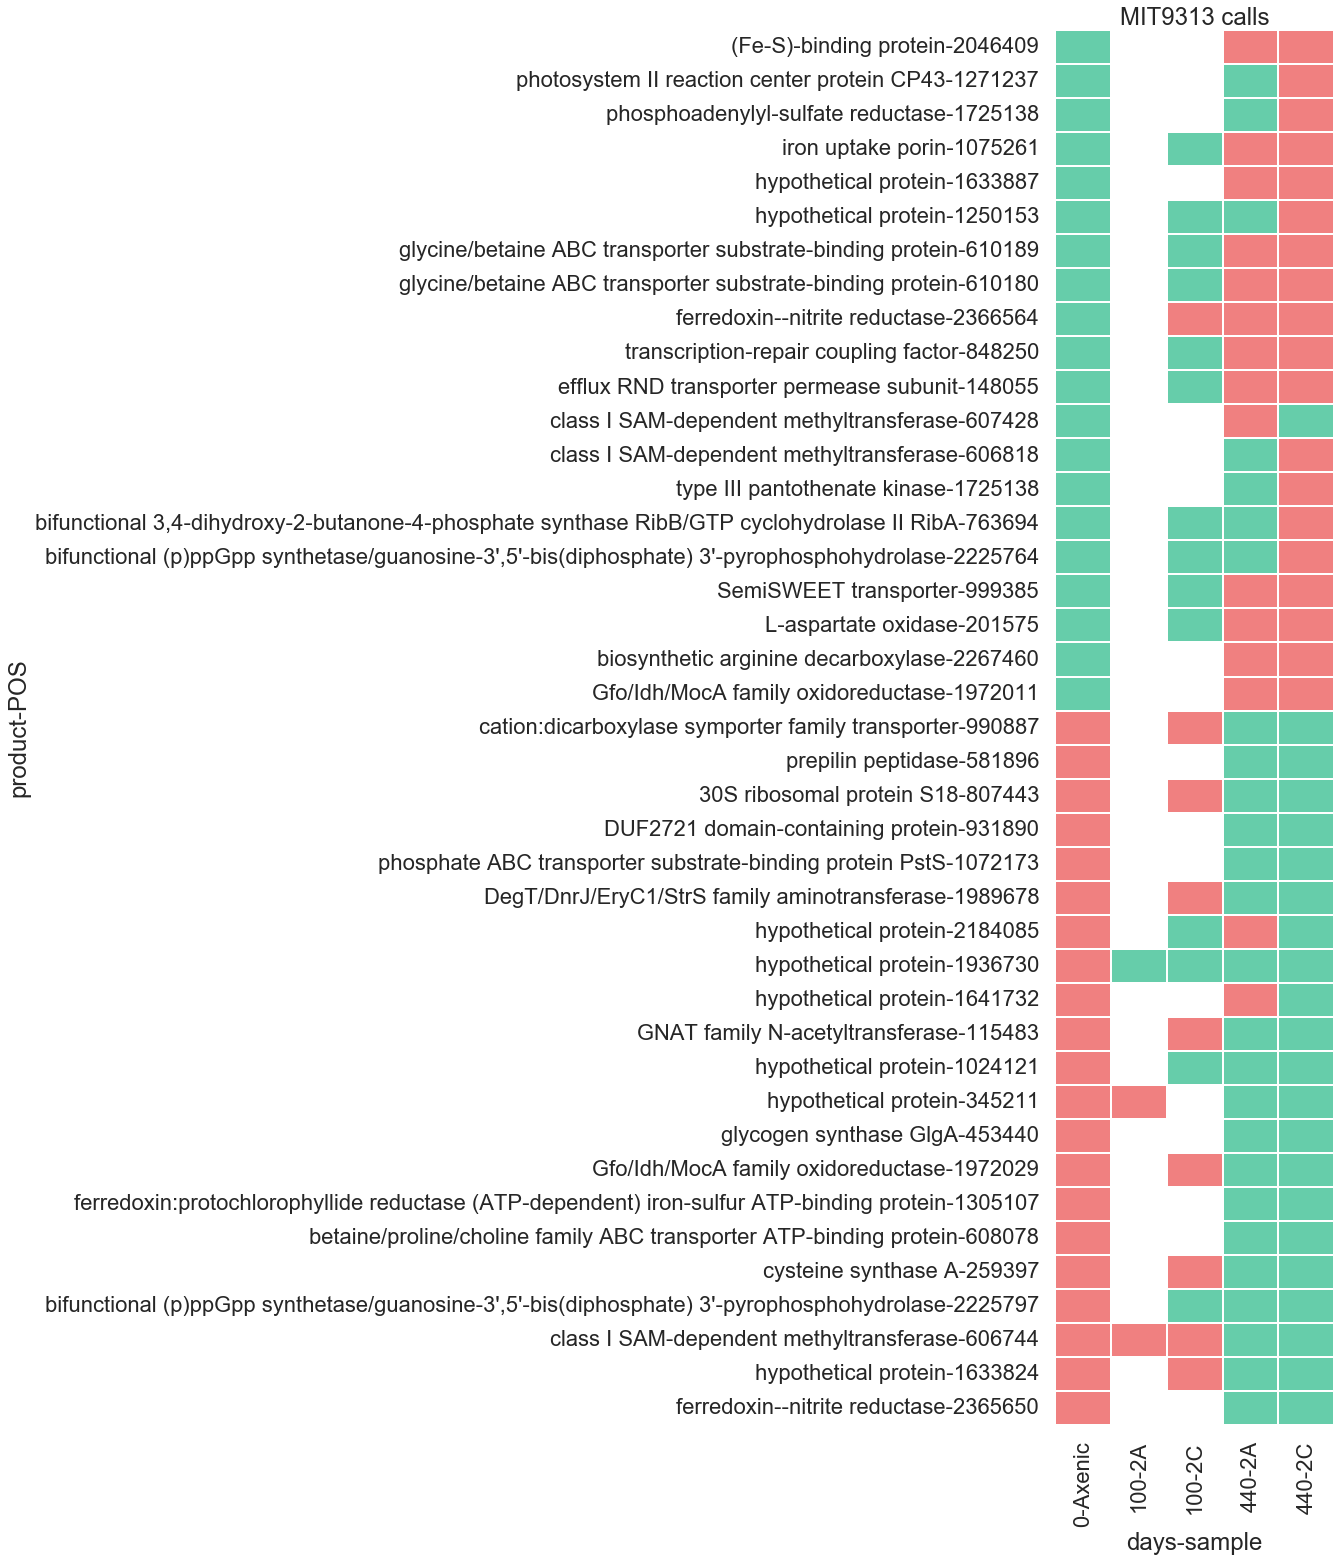

In [272]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'product','POS',], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1].sort_values((  0, 'Axenic')),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

Text(0.5, 1, 'MIT0604 calls')

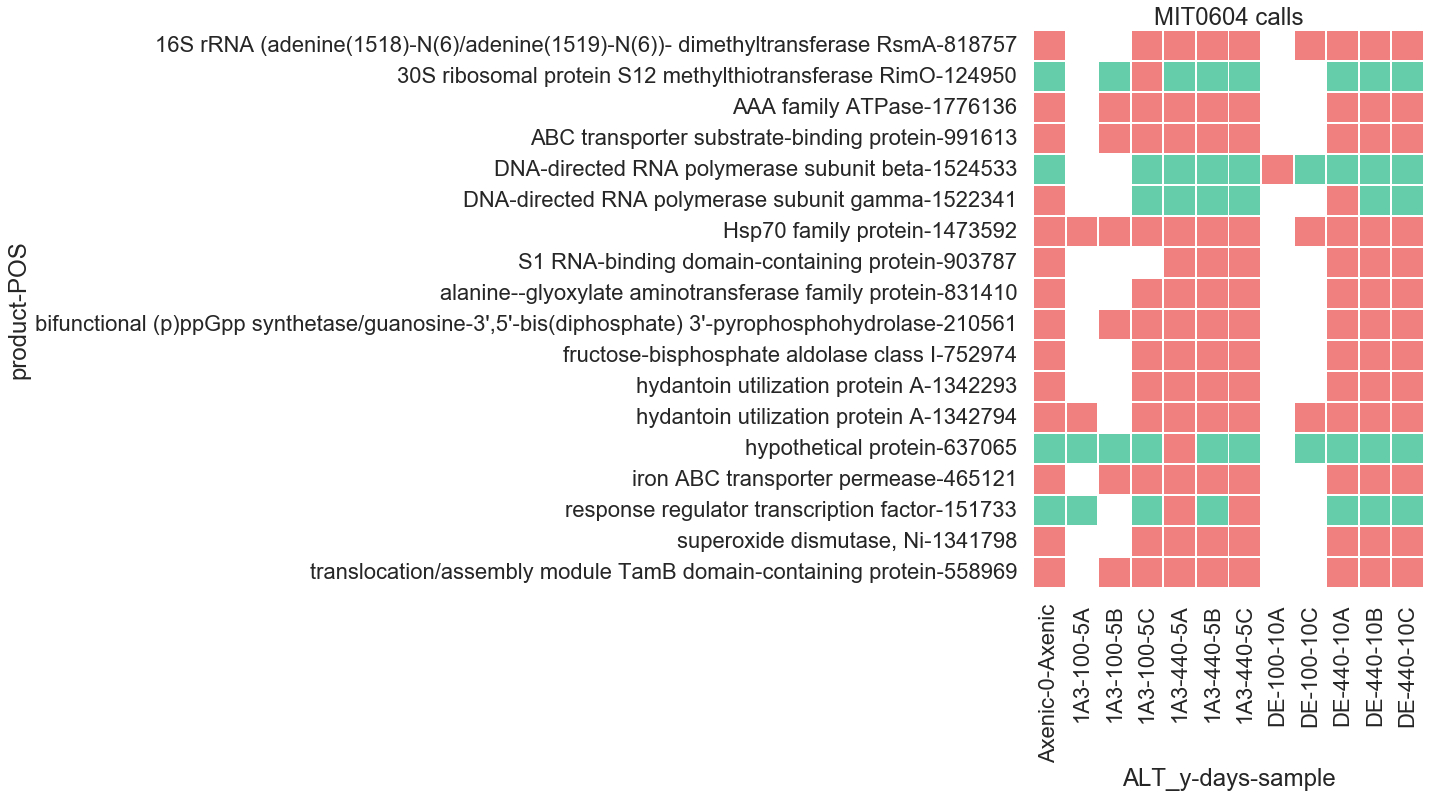

In [290]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'product','POS',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

Text(0.5, 1, 'MIT0604 calls')

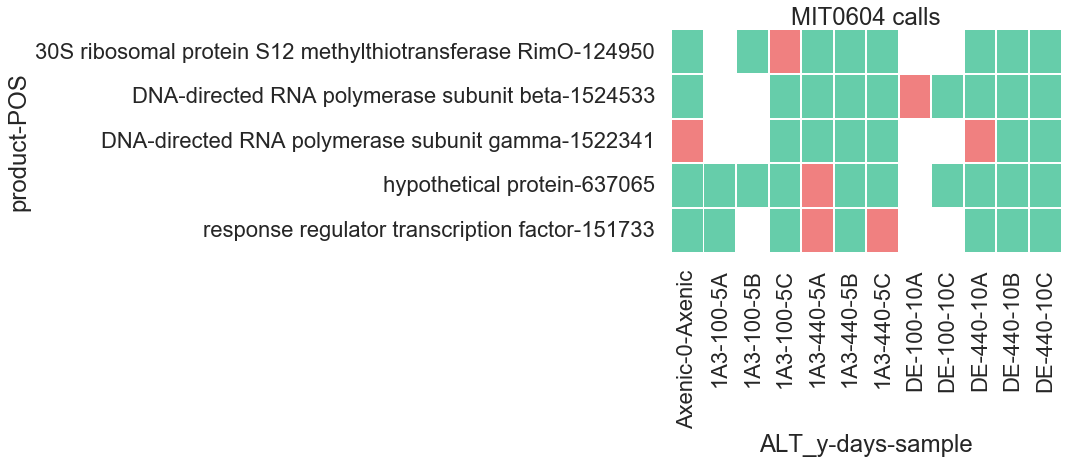

In [289]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'product','POS',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

Text(0.5, 1, 'MIT9313: fraction of Alternate Allele')

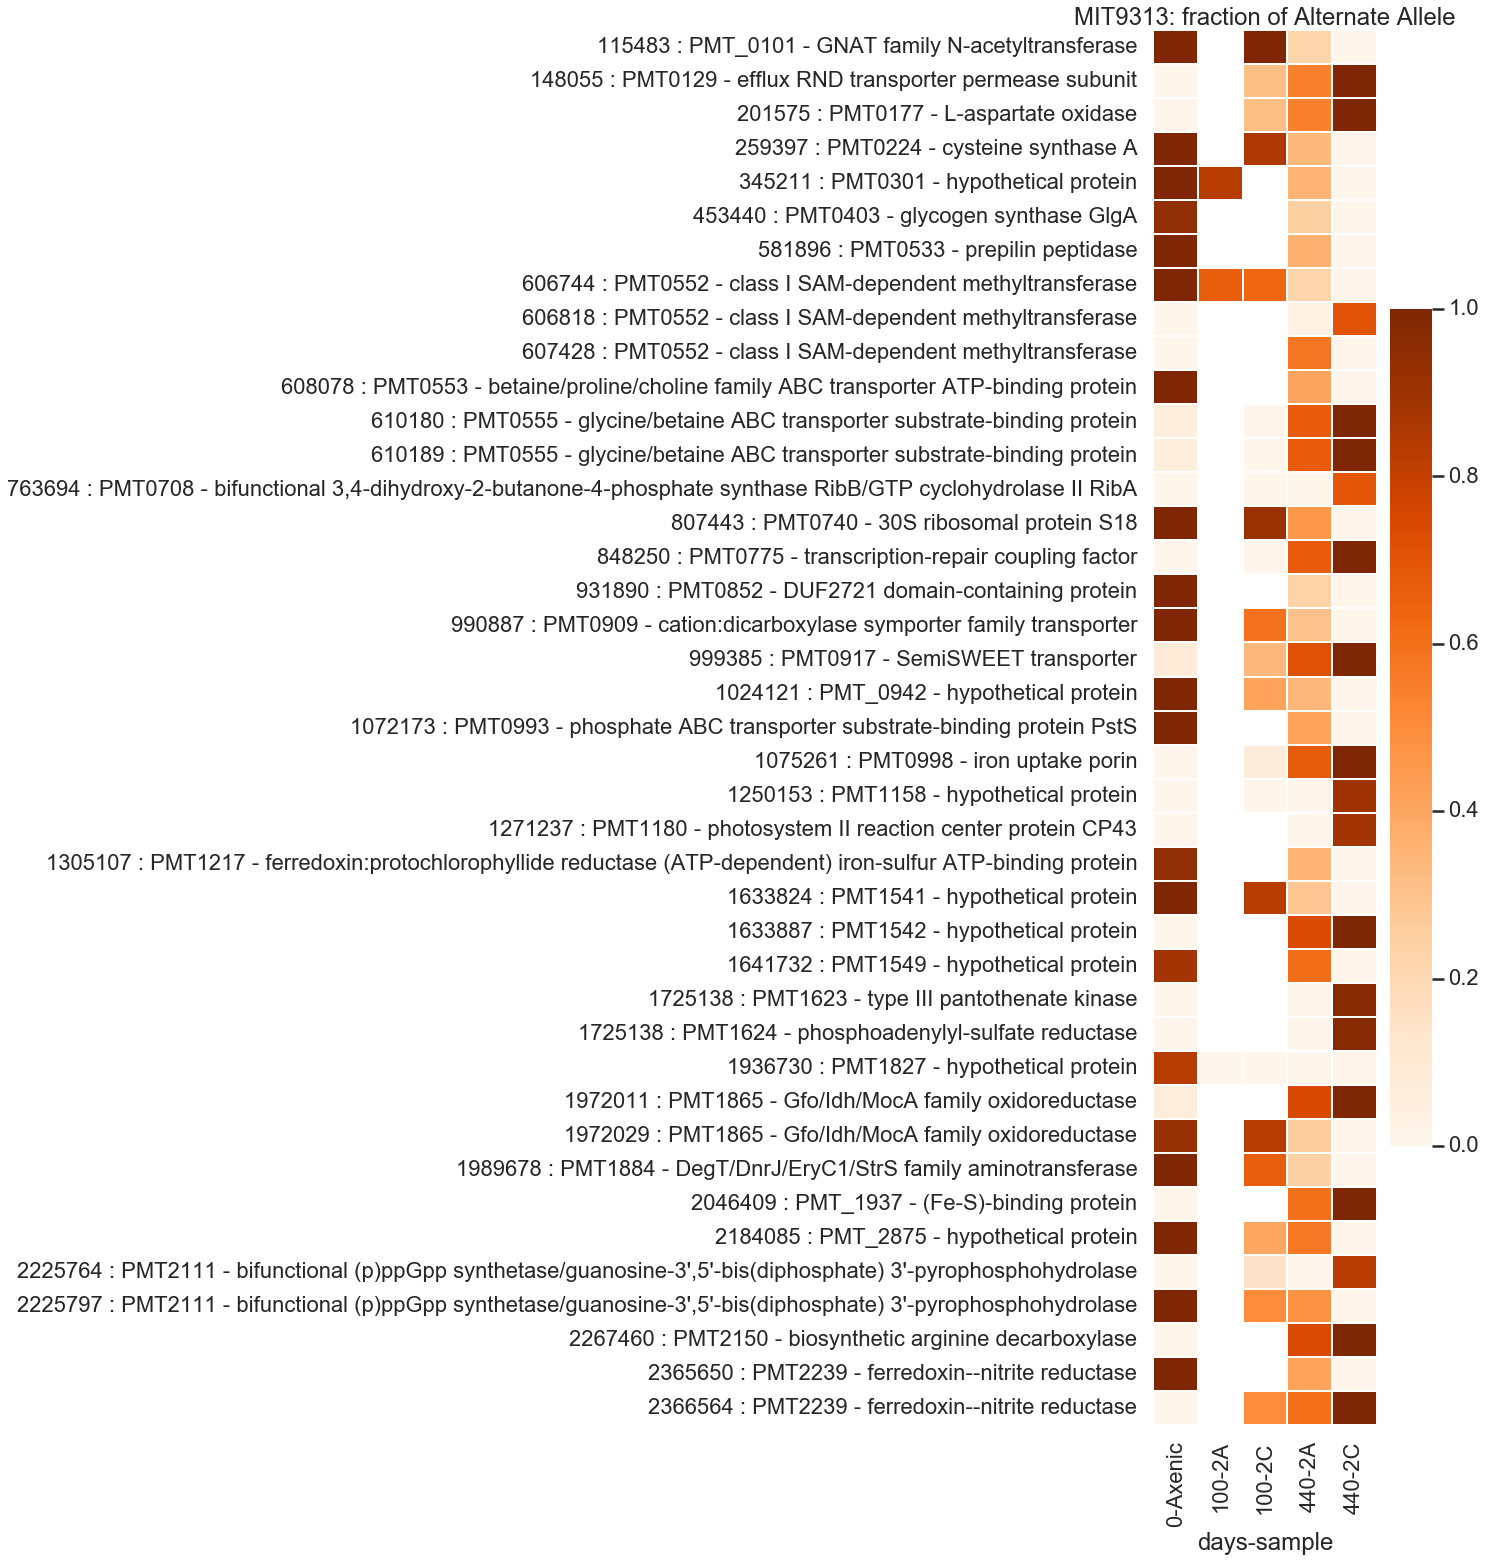

In [315]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=[ 'POS', 'PMTID1', 'product',], 
                                                columns=[ 'days','sample',], values='fraction_Alt', aggfunc='first')
pvdf.index = [f'{col[0]} : {col[1]} - {col[2]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

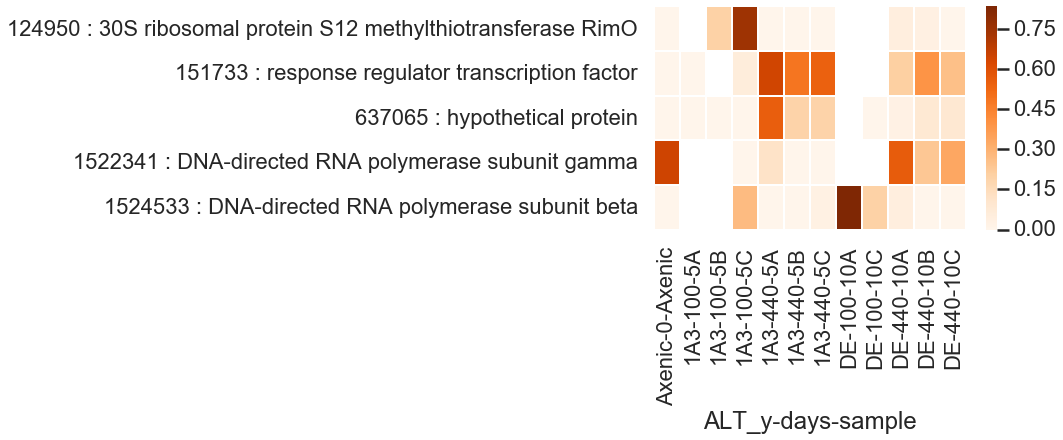

In [313]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=[ 'POS', 'product',], 
                                                columns=[ 'ALT_y', 'days','sample',], values='fraction_Alt', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

Text(0.5, 1, 'MIT0604: fraction of Alternate Allele')

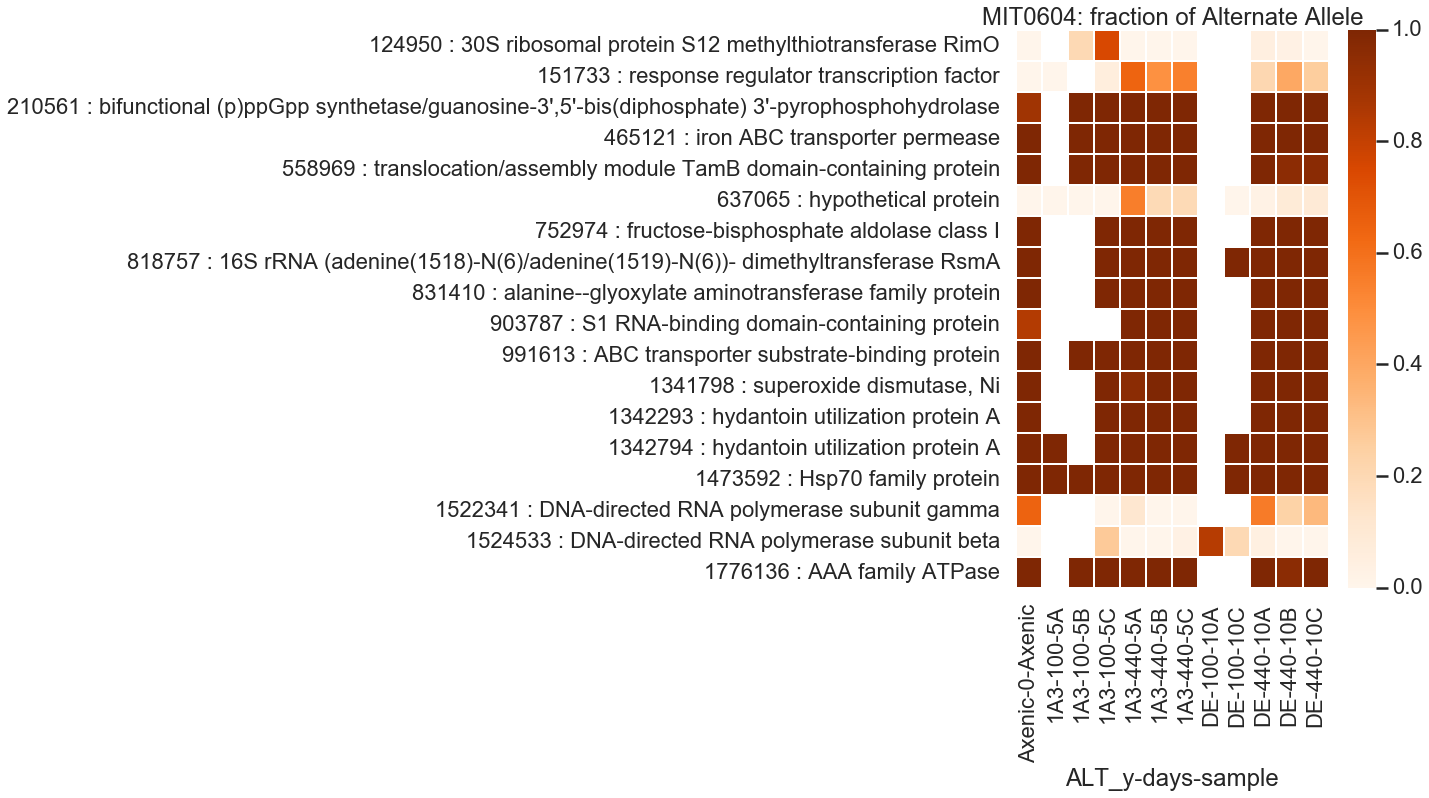

In [318]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & 
                         dfs[species].good_call & 
                        (dfs[species].PRO == species)
               ].pivot_table(index=[ 'POS', 'product',], 
                             columns=[ 'ALT_y', 'days','sample',], 
                             values='fraction_Alt', aggfunc='first', #dropna=False
                            )
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

In [312]:
pvdf.head()

ALT_y                                              Axenic 1A3                \
days                                                  0   100        440      
sample                                             Axenic  5A  5B 5C  5A 5B   
124950 : 30S ribosomal protein S12 methylthiotr...      0 nan   0  1   0  0   
151733 : response regulator transcription factor        0   0 nan  0   1  0   
210561 : bifunctional (p)ppGpp synthetase/guano...      1 nan   1  1   1  1   
465121 : iron ABC transporter permease                  1 nan   1  1   1  1   
558969 : translocation/assembly module TamB dom...      1 nan   1  1   1  1   

ALT_y                                                  DE                  
days                                                  100     440          
sample                                             5C 10A 10C 10A 10B 10C  
124950 : 30S ribosomal protein S12 methylthiotr...  0 nan nan   0   0   0  
151733 : response regulator transcription factor    1 nan nan   0   0   0  
210561 : bifunctional (p)ppGpp synthetase/guano...  1 nan nan   1   1   1  
465121 : iron ABC transporter permease              1 nan nan   1   1   1  
558969 : translocation/assembly module TamB dom...  1 nan nan   1   1   1

Text(0.5, 1.0, 'location on the genome')

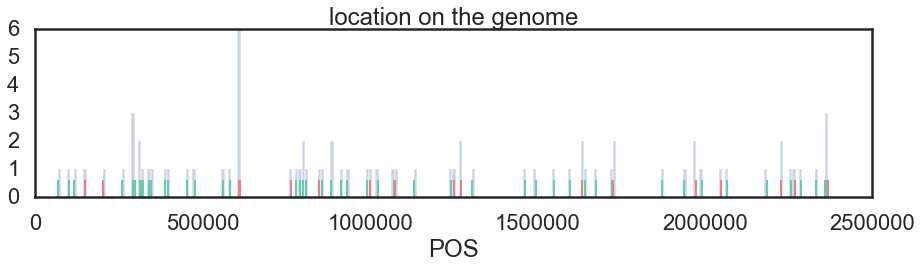

In [147]:
plt.figure(figsize=(15,3))
pvdf = mpdf.loc[mpdf.type == 'CDS'].pivot_table(index=[ 'product','POS',], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')

#from matplotlib import collections  as mc
sns.distplot(pvdf.reset_index()['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.3))
ax = sns.rugplot(pvdf.loc[pvdf[(0,'Axenic')]==1].reset_index()['POS'], height=0.1, c='MediumAquamarine', lw=2)
ax = sns.rugplot(pvdf.loc[pvdf[(0,'Axenic')]==0].reset_index()['POS'], height=0.1, c='lightcoral', lw=2)

#sns.scatterplot(x=pvdf['POS'], pvdf[(0,'Axenic')]
#import pylab as pl

#lines = [[(0, 1), (1, 1)], [(2, 3), (3, 3)], [(1, 2), (1, 3)]]
#df_genome_MIT9313[['left', 'right'], ]

#lc = mc.LineCollection(lines, colors=c, linewidths=2)
#fig, ax = pl.subplots()
#ax.add_collection(lc)
#ax.autoscale()
#ax.margins(0.1)
plt.title('location on the genome')

In [103]:
pvdf.head()

days                                                0   100       440     
sample                                           Axenic  2A   2C   2A   2C
product                                  POS                              
(Fe-S)-binding protein                   2046409    0.0 NaN  NaN  1.0  1.0
30S ribosomal protein S18                807443     1.0 NaN  1.0  0.0  0.0
ATP-binding protein                      882382     1.0 NaN  1.0  1.0  1.0
                                         882422     1.0 NaN  NaN  1.0  1.0
DNA-directed RNA polymerase subunit beta 1595971    1.0 NaN  NaN  1.0  1.0

In [ ]:
plt.plot()

# Unmapped BLAST

In [51]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
unmapped_df = pd.read_csv('contigs.fasta.nt.blastn', names=unmapped_header, sep='\t', comment='#')

In [52]:
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [53]:
unmapped_df.head()

,query id,subject id,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,subject tax ids,subject sci names,contig,contig length,contig coverage
0,NODE_1_length_1767948_cov_30.907998,gi|114339016|gb|CP000449.1|,78.454,9691,1805,218,338548,348119,788143,778617,0.0,6067.0,394221,Maricaulis maris MCS10,1,1767948,30.907998
1,NODE_1_length_1767948_cov_30.907998,gi|114339016|gb|CP000449.1|,84.254,4636,684,41,1354430,1359040,3088118,3092732,0.0,4475.0,394221,Maricaulis maris MCS10,1,1767948,30.907998
2,NODE_1_length_1767948_cov_30.907998,gi|114339016|gb|CP000449.1|,80.084,5262,946,86,148832,154038,986635,981421,0.0,3818.0,394221,Maricaulis maris MCS10,1,1767948,30.907998
3,NODE_1_length_1767948_cov_30.907998,gi|114339016|gb|CP000449.1|,78.601,5505,1006,134,1236626,1242048,3147041,3152455,0.0,3482.0,394221,Maricaulis maris MCS10,1,1767948,30.907998
4,NODE_1_length_1767948_cov_30.907998,gi|114339016|gb|CP000449.1|,81.400,4215,699,67,321974,326150,808288,804121,0.0,3362.0,394221,Maricaulis maris MCS10,1,1767948,30.907998


In [55]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

,alignment length,contig,bit score
subject sci names,,,
Alteromonas macleodii,7460367,2066,6248
Alteromonas macleodii ATCC 27126,3022314,2002,2091
Alteromonas macleodii str. 'English Channel 673',2611950,1954,2056
Alteromonas mediterranea,2469162,922,2750
Alteromonas macleodii str. 'Balearic Sea AD45',2458683,1900,2067
Alteromonas macleodii str. 'Black Sea 11',1860123,1514,1677
Maricaulis maris MCS10,955015,14,584
Alteromonas sp. BL110,918890,852,946
Methylophaga nitratireducenticrescens,743174,38,488


In [57]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
unmapped_df = pd.read_csv(os.path.join('DNA', 'unmapped.axenic.nt.blastn'), names=unmapped_header, sep='\t', comment='#')
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [58]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

,alignment length,contig,bit score
subject sci names,,,
Methylophaga nitratireducenticrescens,564285,162,492
Methylophaga frappieri,178618,105,152
Maricaulis maris MCS10,40090,82,86
Pseudomonas aeruginosa,35059,10,43
Serratia marcescens,32122,12,49
Pseudomonas putida,26851,29,38
Pseudomonas fluorescens,26231,28,43
Morganella morganii,25813,8,38
Pseudomonas chlororaphis subsp. piscium,23855,3,25


In [65]:
data_dpath = os.path.join('DNA','kraken_unmapped')
def _parse_csv(i):
    fpath = os.path.join(data_dpath, f'{160000+i}.bracken.species.txt')
    df =  pd.read_csv(fpath, sep='\t') 
    df['sample_number'] = i
    return df
tmpdf = [_parse_csv(i) for i in [4] + list(range(10,22))]
kraken_unmapped_gdf =pd.concat(tmpdf)
kraken_unmapped_gdf = pd.merge(kraken_unmapped_gdf, meta_df, on='sample_number', how='left')

In [66]:
kraken_unmapped_gdf.sample_number.value_counts().sort_index()

4     463
10    509
11    228
12    590
13    219
14    666
15    258
16    563
17    436
18    457
19    257
20    542
21    248
Name: sample_number, dtype: int64

In [67]:
kraken_unmapped_gdf.columns

Index(['name', 'taxonomy_id', 'taxonomy_lvl', 'kraken_assigned_reads',
       'added_reads', 'new_est_reads', 'fraction_total_reads', 'sample_number',
       'sample', 'PRO', 'ALT', 'exp', 'days', 'ng/ul', 'final volume'],
      dtype='object')

Text(0.5, 1, '% unmapped reads')

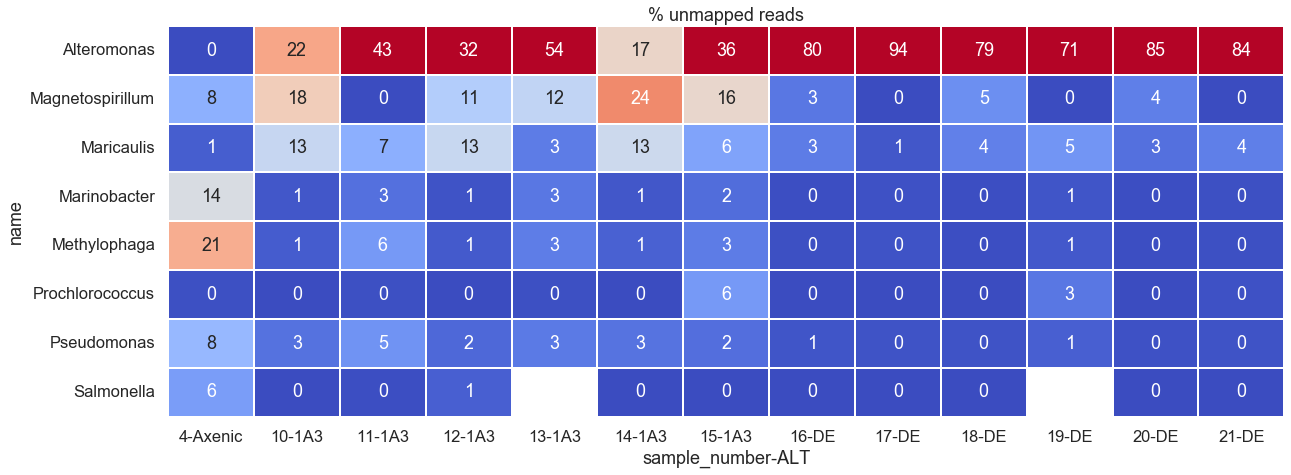

In [91]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='fraction_total_reads')
sns.heatmap(pkraken_unmapped_gdf*100, cmap='coolwarm', annot=True, vmax=30,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
plt.title('% unmapped reads', y=1)

Text(0.5, 1, 'unmapped reads')

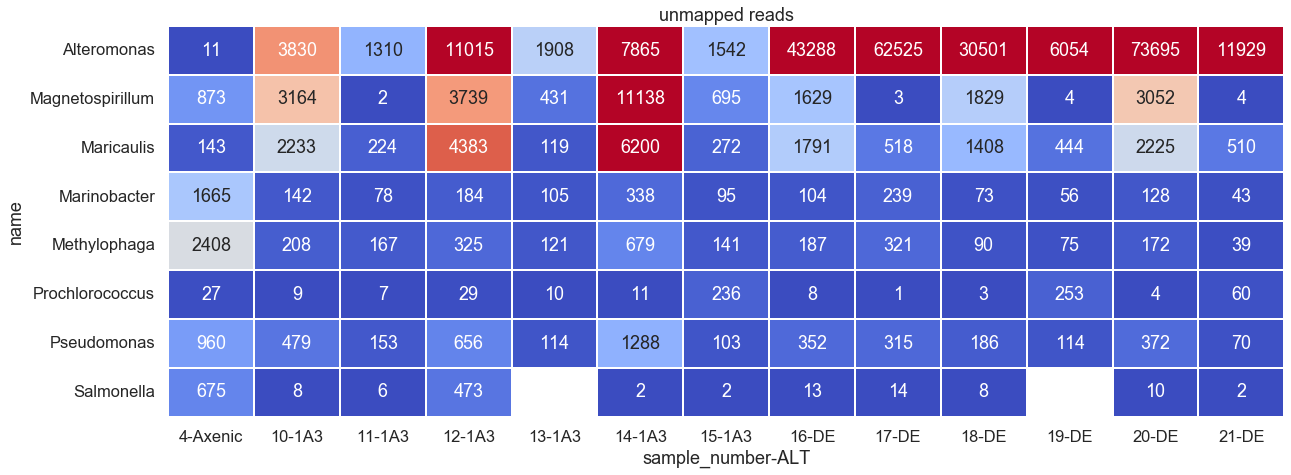

In [95]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='new_est_reads')
sns.heatmap(pkraken_unmapped_gdf, cmap='coolwarm', annot=True, vmax=5000,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
            
plt.title('unmapped reads', y=1)